# Wind Farms (Foreshore Process)

<https://data.gov.ie/dataset/wind-farms-foreshore-process>

In [1]:
import os
from datetime import datetime, timezone
from zipfile import ZipFile

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pooch
from matplotlib_scalebar.scalebar import ScaleBar

from src import functions as fns

In [2]:
# base data download directory
DATA_DIR = os.path.join("data", "wind-farms-foreshore-process")
os.makedirs(DATA_DIR, exist_ok=True)

URL = (
    "https://opendata.arcgis.com/api/v3/datasets/"
    "803a4ecc22aa4cc09111072a0bbc4fac_2/downloads/"
    "data?format=shp&spatialRefId=4326&where=1%3D1"
)
KNOWN_HASH = None
FILE_NAME = "wind-farms-foreshore-process.zip"

DATA_FILE = os.path.join(DATA_DIR, FILE_NAME)

# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

In [3]:
# download data if necessary
if not os.path.isfile(DATA_FILE):
    pooch.retrieve(
        url=URL,
        known_hash=KNOWN_HASH,
        fname=FILE_NAME,
        path=DATA_DIR
    )

    with open(f"{DATA_FILE[:-4]}.txt", "w", encoding="utf-8") as outfile:
        outfile.write(
            f"Data downloaded on: {datetime.now(tz=timezone.utc)}\n"
            f"Download URL: {URL}"
        )

SHA256 hash of downloaded file: eb0f0c1b14a0db959b47795a623d0e8b74bfb32285656905ae30136a4e34446b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [3]:
with open(f"{DATA_FILE[:-4]}.txt") as f:
    print(f.read())

Data downloaded on: 2023-09-11 14:08:54.610561+00:00
Download URL: https://opendata.arcgis.com/api/v3/datasets/803a4ecc22aa4cc09111072a0bbc4fac_2/downloads/data?format=shp&spatialRefId=4326&where=1%3D1


In [3]:
ZipFile(DATA_FILE).namelist()

['Energy_Offshore_Renewable.shp',
 'Energy_Offshore_Renewable.shx',
 'Energy_Offshore_Renewable.dbf',
 'Energy_Offshore_Renewable.cpg',
 'Energy_Offshore_Renewable.prj',
 'Energy_Offshore_Renewable.xml']

In [3]:
wind_farms = gpd.read_file(
    os.path.join(
        f"zip://{DATA_FILE}!" +
        [x for x in ZipFile(DATA_FILE).namelist() if x.endswith(".shp")][0]
    )
)

In [4]:
wind_farms.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
wind_farms.shape

(19, 23)

In [6]:
wind_farms.columns

Index(['OBJECTID', 'Name', 'Type', 'MDM_Catego', 'NMPF_Chapt', 'NMPF_Cha_1',
       'Map_Featur', 'Map_Data_S', 'Last_Updat', 'Policy01_N', 'Policy02_N',
       'Policy03_N', 'Owning_Org', 'Metadata_L', 'Policy01_P', 'Policy01_C',
       'Policy02_P', 'Policy02_C', 'Policy03_P', 'Policy03_C', 'Shape__Are',
       'Shape__Len', 'geometry'],
      dtype='object')

In [7]:
wind_farms[["Name", "Type", "MDM_Catego"]]

,Name,Type,MDM_Catego
0,Arklow Bank Phase 2,Fixed-Bottom,Site Investigations
1,Kilmichael Point\r\nKilmichael Point,Fixed-Bottom,Site Investigations
2,Codling Wind Park Extension,Fixed-Bottom,Relevant Projects
3,Codling Wind Park,Fixed-Bottom,Relevant Projects
4,Dublin Array,Fixed-Bottom,Relevant Projects
5,Oriel Wind Farm,Fixed-Bottom,Relevant Projects
6,Clogher Head,Fixed-Bottom,Site Investigations
7,North Irish Sea Array (NISA),Fixed-Bottom,Relevant Projects
8,Sceirde (Skerd) Rocks,Fixed-Bottom,Relevant Projects
9,Arklow Bank Phase I,Fixed-Bottom,Fully Commissioned


In [4]:
# minor name fix
wind_farms.at[1, "Name"] = "Kilmichael Point"

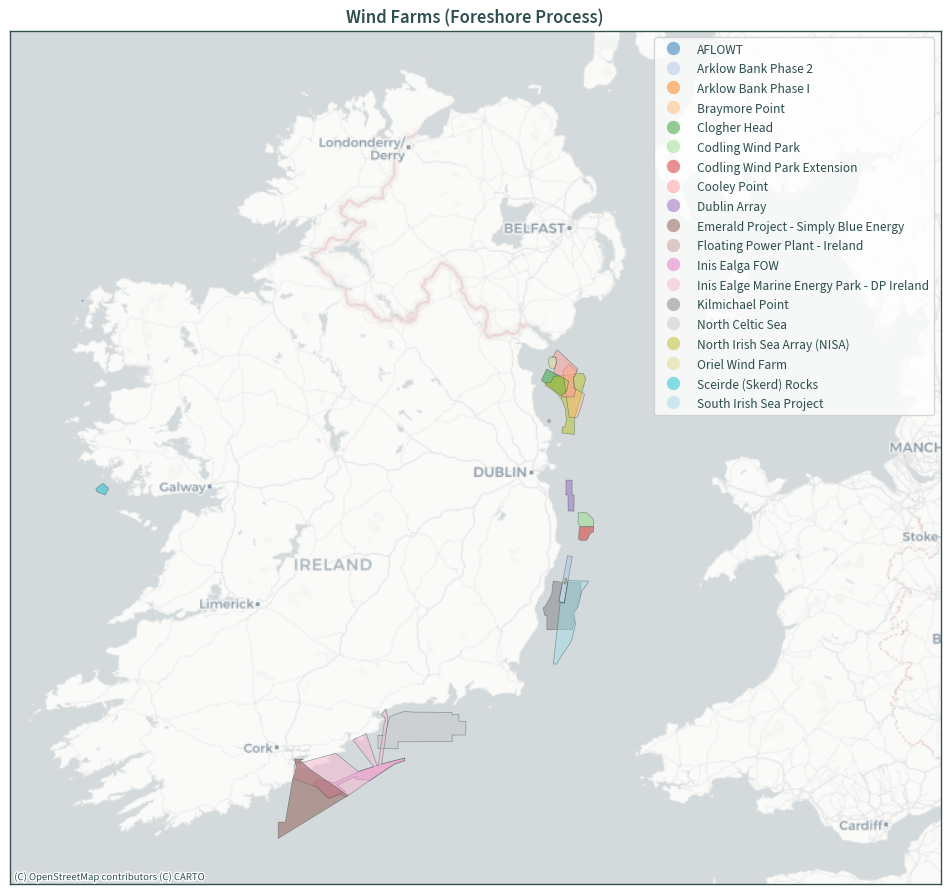

In [5]:
ax = wind_farms.to_crs(3857).plot(
    column="Name", cmap="tab20", alpha=.5, figsize=(10, 10), legend=True,
    legend_kwds={"loc": "upper right"},
    linewidth=.5, edgecolor="darkslategrey"
)
plt.xlim(-1.2e6, -0.3e6)
plt.ylim(6.65e6, 7.475e6)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=7)

plt.title("Wind Farms (Foreshore Process)")

plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

In [5]:
# read Kish Basin data
DATA_DIR = os.path.join("data", "kish-basin")

CRS = 23029

ds, extent = fns.read_dat_file(DATA_DIR, CRS)

# use extent bounds
xmin, ymin, xmax, ymax = extent.total_bounds

In [7]:
# wind farms in the Irish Sea
wind_farms_ = wind_farms.sjoin(
    gpd.GeoDataFrame(geometry=extent.buffer(50000)).to_crs(wind_farms.crs)
)

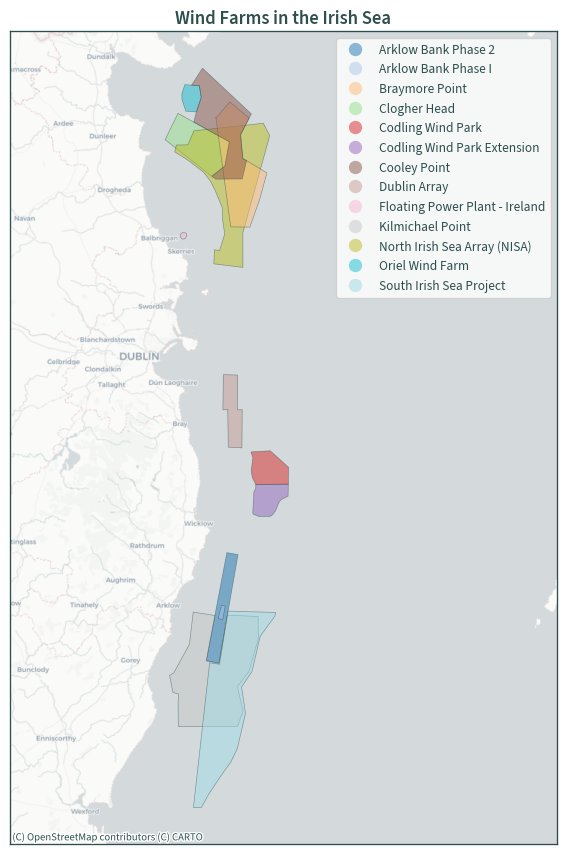

In [10]:
ax = wind_farms_.to_crs(3857).plot(
    column="Name", alpha=.5, figsize=(9, 9), cmap="tab20",
    linewidth=.5, edgecolor="darkslategrey", legend=True
)
plt.xlim(-7.5e5, -5.25e5)
extent.to_crs(3857).boundary.plot(ax=ax, alpha=0)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

plt.title("Wind Farms in the Irish Sea")
plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

In [9]:
# wind farms near Kish Basin
wind_farms_ = wind_farms.sjoin(
    gpd.GeoDataFrame(geometry=extent.buffer(3000)).to_crs(wind_farms.crs)
).reset_index().sort_values("Name")

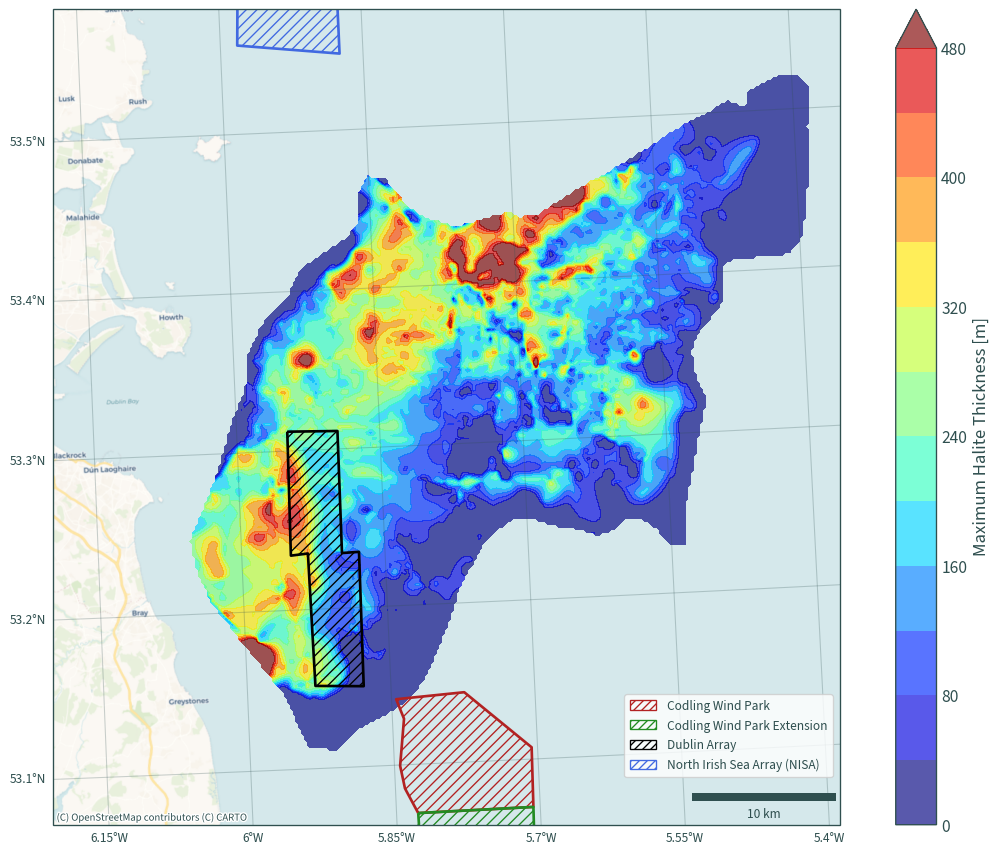

In [14]:
plt.figure(figsize=(12, 9))
ax = plt.axes(projection=ccrs.epsg(CRS))

ds.max(dim="halite")["Thickness"].plot.contourf(
    cmap="jet",
    alpha=.65,
    robust=True,
    levels=15,
    cbar_kwargs={"label": "Maximum Halite Thickness [m]"}
)

plt.xlim(xmin, xmax)
plt.ylim(ymin - 4000, ymax + 4000)

# wind farms
colours = ["firebrick", "forestgreen", "black", "royalblue"]
for index, colour in zip(range(len(wind_farms_)), colours):
    wind_farms_.iloc[[index]].to_crs(CRS).plot(
        ax=ax, hatch="///", facecolor="none", edgecolor=colour, linewidth=2
    )
legend_handles = [
    mpatches.Patch(
        facecolor="none", hatch="////", edgecolor=colours[x],
        label=list(wind_farms_["Name"])[x]
    ) for x in range(len(wind_farms_))
]

cx.add_basemap(ax, crs=CRS, source=cx.providers.CartoDB.Voyager)
ax.gridlines(
    draw_labels={"bottom": "x", "left": "y"}, alpha=.25, color="darkslategrey"
)
ax.add_artist(
    ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
)
ax.legend(
    handles=legend_handles, loc="lower right", bbox_to_anchor=(1, 0.05)
)

# plt.title("Wind Farms near Kish Basin")
plt.title(None)
plt.tight_layout()
plt.show()